# PoDS 22/23 Week 6

* revisiting grouping and aggregation with `.groupby` (we had a taster at the week 3's webinar).

* further resources:
    - [split-apply-combine illustration](https://jakevdp.github.io/PythonDataScienceHandbook/03.08-aggregation-and-grouping.html#Split,-apply,-combine)
    - [Python Data Science Handbook](https://learning.oreilly.com/library/view/python-data-science/9781491912126/ch03.html#aggregation-and-grouping-pandas)
    - [Pandas GroupBy Guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html)

## The Usual Preamble

In [1]:
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='talk', font_scale=0.8, rc={'figure.figsize': (10,6)} )

## Datasets

We will make use of the familiar `gapminder` for some of examples and exercises.

In [2]:
ds = 'https://raw.githubusercontent.com/gerberl/6G7V0026-2223/main/datasets/gapminder.tsv'
gm = pd.read_csv(ds, sep='\t')

A quick check:

In [3]:
gm.sample()

,country,continent,year,lifeExp,pop,gdpPercap
116,Belgium,Europe,1992,76.46,10045622,25575.57069


Also, the titanic dataset:

In [4]:
ds = 'https://raw.githubusercontent.com/gerberl/6G7V0026-2223/main/datasets/titanic-kaggle/titanic.csv'  
titanic = pd.read_csv(ds)

## Examples on `gapminder`

In [5]:
gm_2007 = gm.query('year==2007')

In [6]:
# total population per continent for 2007 (the latest we have on this sample)
gm_2007.groupby('continent')['pop'].sum()

continent
Africa       929539692
Americas     898871184
Asia        3811953827
Europe       586098529
Oceania       24549947
Name: pop, dtype: int64

In [7]:
(gm_2007
 .groupby('continent')   # split data into distinct values of continent (split)
 ['pop']                 # from each partition, take just population
 .sum()                  # for each population vector, take the sum (apply)
                         # (combine) is implicit                          
)

continent
Africa       929539692
Americas     898871184
Asia        3811953827
Europe       586098529
Oceania       24549947
Name: pop, dtype: int64

In [8]:
# how many countries representing each continent?
(gm_2007
 .groupby('continent')   # split
 .size()                 # apply
)

continent
Africa      52
Americas    25
Asia        33
Europe      30
Oceania      2
dtype: int64

In [9]:
# alternatively... but we have to pick one column
(gm_2007
 .groupby('continent')   # split
 .agg('count')           # apply
)

,country,year,lifeExp,pop,gdpPercap
continent,,,,,
Africa,52,52,52,52,52
Americas,25,25,25,25,25
Asia,33,33,33,33,33
Europe,30,30,30,30,30
Oceania,2,2,2,2,2


In [10]:
# to be equivalent to `.size()`, we need to pick a single columns
# also, it makes sense to give the Series a meaningful name
(gm_2007
 .groupby('continent')   # split
 ['pop']
 .count()                # apply
).rename('no_countries')

continent
Africa      52
Americas    25
Asia        33
Europe      30
Oceania      2
Name: no_countries, dtype: int64

In [11]:
# mean averages of `lifeExp`, `pop`, and `gdpPercap` per country
(gm
 .groupby('continent')
 [ ['pop', 'lifeExp', 'gdpPercap' ] ]
 .mean()
)

,pop,lifeExp,gdpPercap
continent,,,
Africa,9.916003e+06,48.865330,2193.754578
Americas,2.450479e+07,64.658737,7136.110356
Asia,7.703872e+07,60.064903,7902.150428
Europe,1.716976e+07,71.903686,14469.475533
Oceania,8.874672e+06,74.326208,18621.609223


In [12]:
# as mentioned in the webinar: it is best to think as groupby as producing
# a stream of DataFrames, once for each group (typically, a group is created
# for unique values of one or more columns, but there are other more flexible
# ways of doing so. Applying `.mean()` over a subset of data is not specific
# to groupby (as a reminder):
gm[ ['pop', 'lifeExp', 'gdpPercap' ] ].mean()

pop          2.960121e+07
lifeExp      5.947444e+01
gdpPercap    7.215327e+03
dtype: float64

In [13]:
# the highest life expectancy by continent and year?
(gm
 .groupby(['continent', 'year'])
 [ ['lifeExp'] ]  # why a list of column names?
 .max()
).head()

lifeExp
continent year         
Africa    1952   52.724
          1957   58.089
          1962   60.246
          1967   61.557
          1972   64.274

`.unstack()` is normally quite useful in combination with grouping. We've seen it before - it turns row labels into column labels:

In [14]:
(gm
 .groupby(['continent', 'year'])
 ['lifeExp']
 .max()
 .unstack('year')
)

year,1952,1957,1962,1967,1972,1977,1982,1987,1992,1997,2002,2007
continent,,,,,,,,,,,,
Africa,52.724,58.089,60.246,61.557,64.274,67.064,69.885,71.913,73.615,74.772,75.744,76.442
Americas,68.750,69.960,71.300,72.130,72.880,74.210,75.760,76.860,77.950,78.610,79.770,80.653
Asia,65.390,67.840,69.390,71.430,73.420,75.380,77.110,78.670,79.360,80.690,82.000,82.603
Europe,72.670,73.470,73.680,74.160,74.720,76.110,76.990,77.410,78.770,79.390,80.620,81.757
Oceania,69.390,70.330,71.240,71.520,71.930,73.490,74.740,76.320,77.560,78.830,80.370,81.235


A more complex expression involving grouping, subsetting, and reshaping can give us some more interesting plots for groups comparisons and insights:

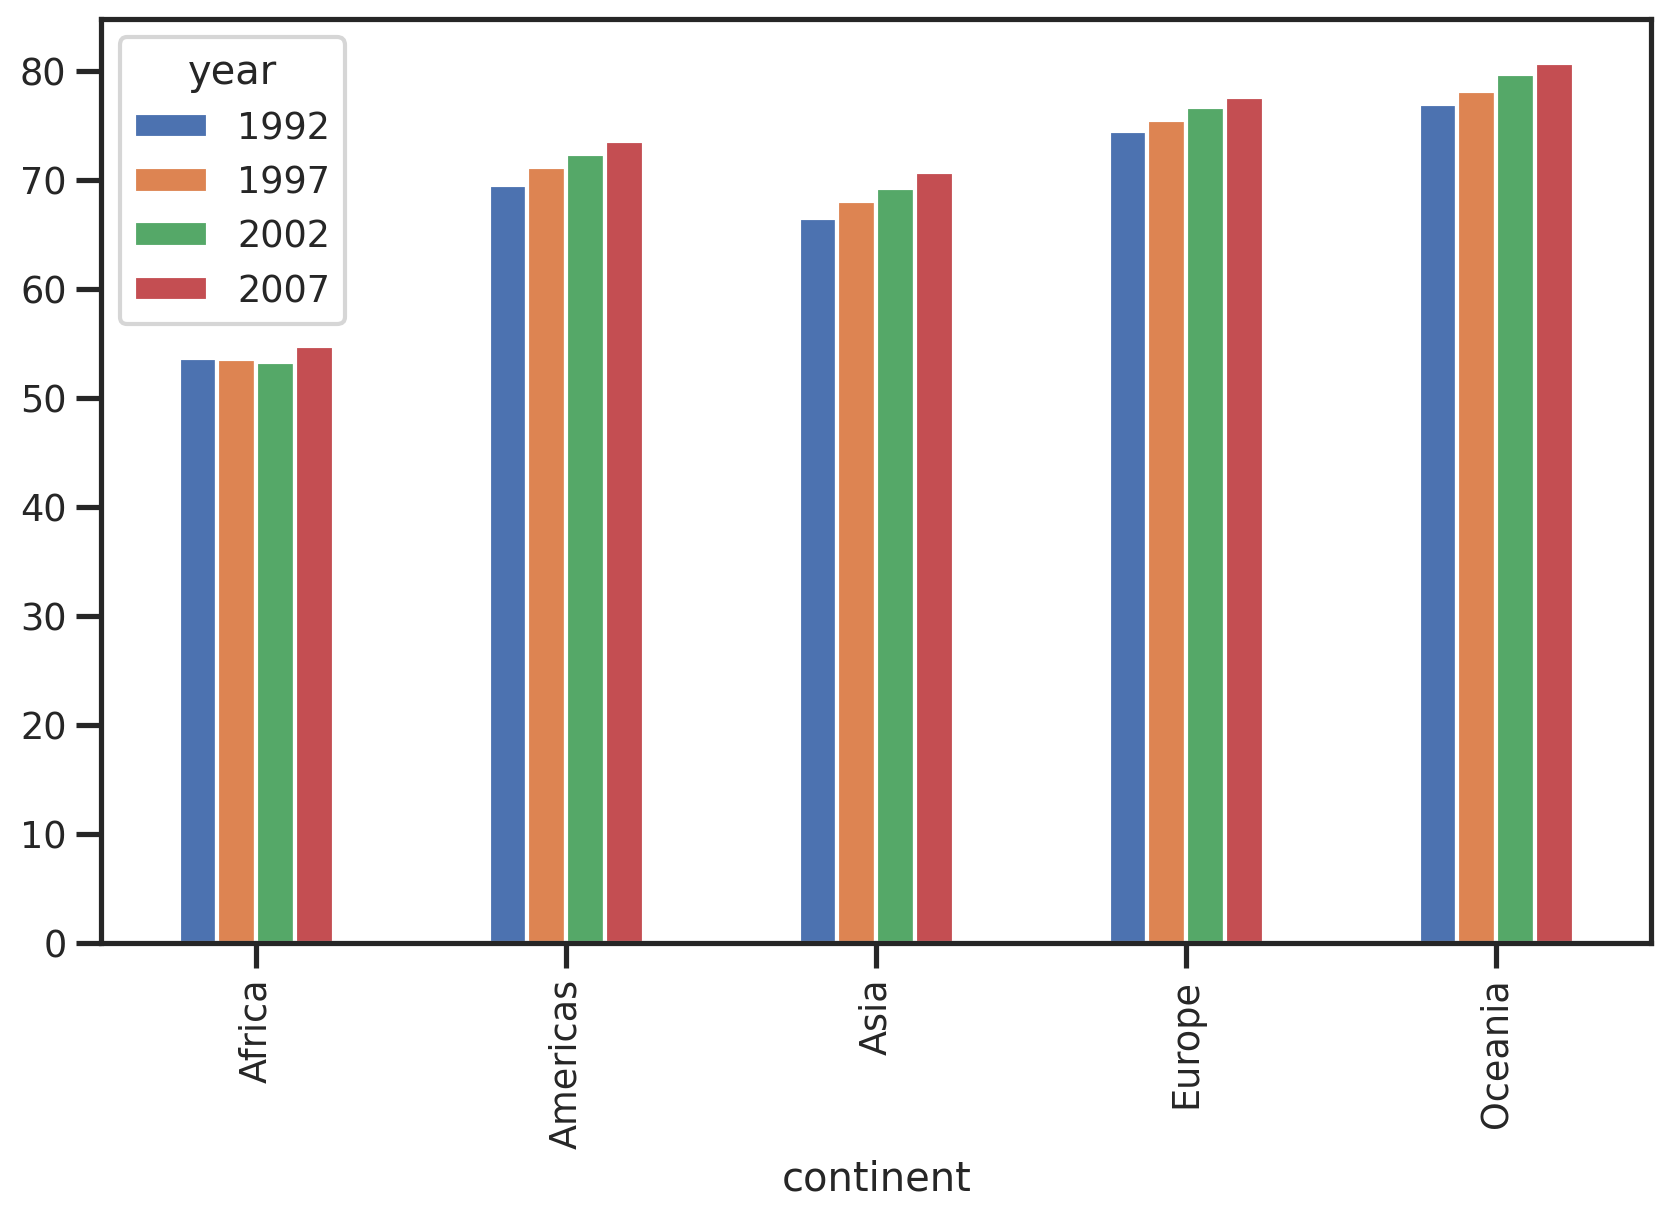

In [15]:
(gm
 .groupby(['continent', 'year'])
 ['lifeExp']
 .mean()
 .unstack('year')
 .loc[:, 1992:2007]
 .plot.bar()
);

How does `.plot.bar()` above actually works? `pandas` adds a layer over `matplotlib` that is available via the `.plot` property of a DataFrame. Normally, the row index is used for the x-axis and the column(s) are used for the y-axis (data series).

In [16]:
df = gm.groupby(['continent', 'year'])['lifeExp'].mean().unstack('year').loc[:, 1992:2007]
print(df.index)
print(df.columns)

Index(['Africa', 'Americas', 'Asia', 'Europe', 'Oceania'], dtype='object', name='continent')
Int64Index([1992, 1997, 2002, 2007], dtype='int64', name='year')


## Some Further Grouping Examples with `gapminder`

One can obtain more than one aggregate value for groups produced by `.groupby()`. If it is more than column, we normally end up with a hierarchical column index.

In [17]:
gm.groupby(['country'])['lifeExp'].agg(['min', 'max', 'mean'])

,min,max,mean
country,,,
Afghanistan,28.801,43.828,37.478833
Albania,55.230,76.423,68.432917
Algeria,43.077,72.301,59.030167
Angola,30.015,42.731,37.883500
Argentina,62.485,75.320,69.060417
...,...,...,...
Vietnam,40.412,74.249,57.479500
West Bank and Gaza,43.160,73.422,60.328667
"Yemen, Rep.",32.548,62.698,46.780417


In [18]:
gm.groupby(['country'])[['lifeExp', 'gdpPercap']].agg(['min', 'max', 'mean'])

lifeExp                       gdpPercap                \
                       min     max       mean          min           max   
country                                                                    
Afghanistan         28.801  43.828  37.478833   635.341351    978.011439   
Albania             55.230  76.423  68.432917  1601.056136   5937.029526   
Algeria             43.077  72.301  59.030167  2449.008185   6223.367465   
Angola              30.015  42.731  37.883500  2277.140884   5522.776375   
Argentina           62.485  75.320  69.060417  5911.315053  12779.379640   
...                    ...     ...        ...          ...           ...   
Vietnam             40.412  74.249  57.479500   605.066492   2441.576404   
West Bank and Gaza  43.160  73.422  60.328667  1515.592329   7110.667619   
Yemen, Rep.         32.548  62.698  46.780417   781.717576   2280.769906   
Zambia              39.193  51.821  45.996333  1071.353818   1777.077318   
Zimbabwe            39.989  62.351  52.663167   406.884115    799.362176   

                                 
                           mean  
country                          
Afghanistan          802.674598  
Albania             3255.366633  
Algeria             4426.025973  
Angola              3607.100529  
Argentina           8955.553783  
...                         ...  
Vietnam             1017.712615  
West Bank and Gaza  3759.996781  
Yemen, Rep.         1569.274672  
Zambia              1358.199409  
Zimbabwe             635.858042  

[142 rows x 6 columns]

**Extra, optional material**: An opportunity to illustrate the reverse of `.unstack()`, which is `.stack()`. It takes a column index level (`0` is in outermost level) and makes it a row index level.

In [19]:
df = gm.groupby(['country'])[['lifeExp', 'gdpPercap']].agg(['min', 'max', 'mean'])
df.stack(0)

max         mean          min
country                                                     
Afghanistan gdpPercap   978.011439   802.674598   635.341351
            lifeExp      43.828000    37.478833    28.801000
Albania     gdpPercap  5937.029526  3255.366633  1601.056136
            lifeExp      76.423000    68.432917    55.230000
Algeria     gdpPercap  6223.367465  4426.025973  2449.008185
...                            ...          ...          ...
Yemen, Rep. lifeExp      62.698000    46.780417    32.548000
Zambia      gdpPercap  1777.077318  1358.199409  1071.353818
            lifeExp      51.821000    45.996333    39.193000
Zimbabwe    gdpPercap   799.362176   635.858042   406.884115
            lifeExp      62.351000    52.663167    39.989000

[284 rows x 3 columns]

In [20]:
df.stack(0).unstack()

max                 mean                     min  \
                       gdpPercap lifeExp    gdpPercap    lifeExp    gdpPercap   
country                                                                         
Afghanistan           978.011439  43.828   802.674598  37.478833   635.341351   
Albania              5937.029526  76.423  3255.366633  68.432917  1601.056136   
Algeria              6223.367465  72.301  4426.025973  59.030167  2449.008185   
Angola               5522.776375  42.731  3607.100529  37.883500  2277.140884   
Argentina           12779.379640  75.320  8955.553783  69.060417  5911.315053   
...                          ...     ...          ...        ...          ...   
Vietnam              2441.576404  74.249  1017.712615  57.479500   605.066492   
West Bank and Gaza   7110.667619  73.422  3759.996781  60.328667  1515.592329   
Yemen, Rep.          2280.769906  62.698  1569.274672  46.780417   781.717576   
Zambia               1777.077318  51.821  1358.199409  45.996333  1071.353818   
Zimbabwe              799.362176  62.351   635.858042  52.663167   406.884115   

                            
                   lifeExp  
country                     
Afghanistan         28.801  
Albania             55.230  
Algeria             43.077  
Angola              30.015  
Argentina           62.485  
...                    ...  
Vietnam             40.412  
West Bank and Gaza  43.160  
Yemen, Rep.         32.548  
Zambia              39.193  
Zimbabwe            39.989  

[142 rows x 6 columns]

## Using `.groupby` for Conditional Distributions

### Background

We have used `.value_counts()` and `.groupby` (with `.size()` or `.count()`) to obtain frequency or probability distributions; some scenarios involving comparing groups (e.g., how `Survived` changes for `Sex`).

In [21]:
# a univariate distribution
titanic['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [22]:
# a univariate, normalised distribution (i.e., a probability distribution)
titanic['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

In [23]:
# a joint distribution
titanic[['Sex', 'Survived']].value_counts(sort=False)

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
dtype: int64

In [24]:
(titanic
 .groupby(['Sex', 'Survived'])
 .size()
)

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
dtype: int64

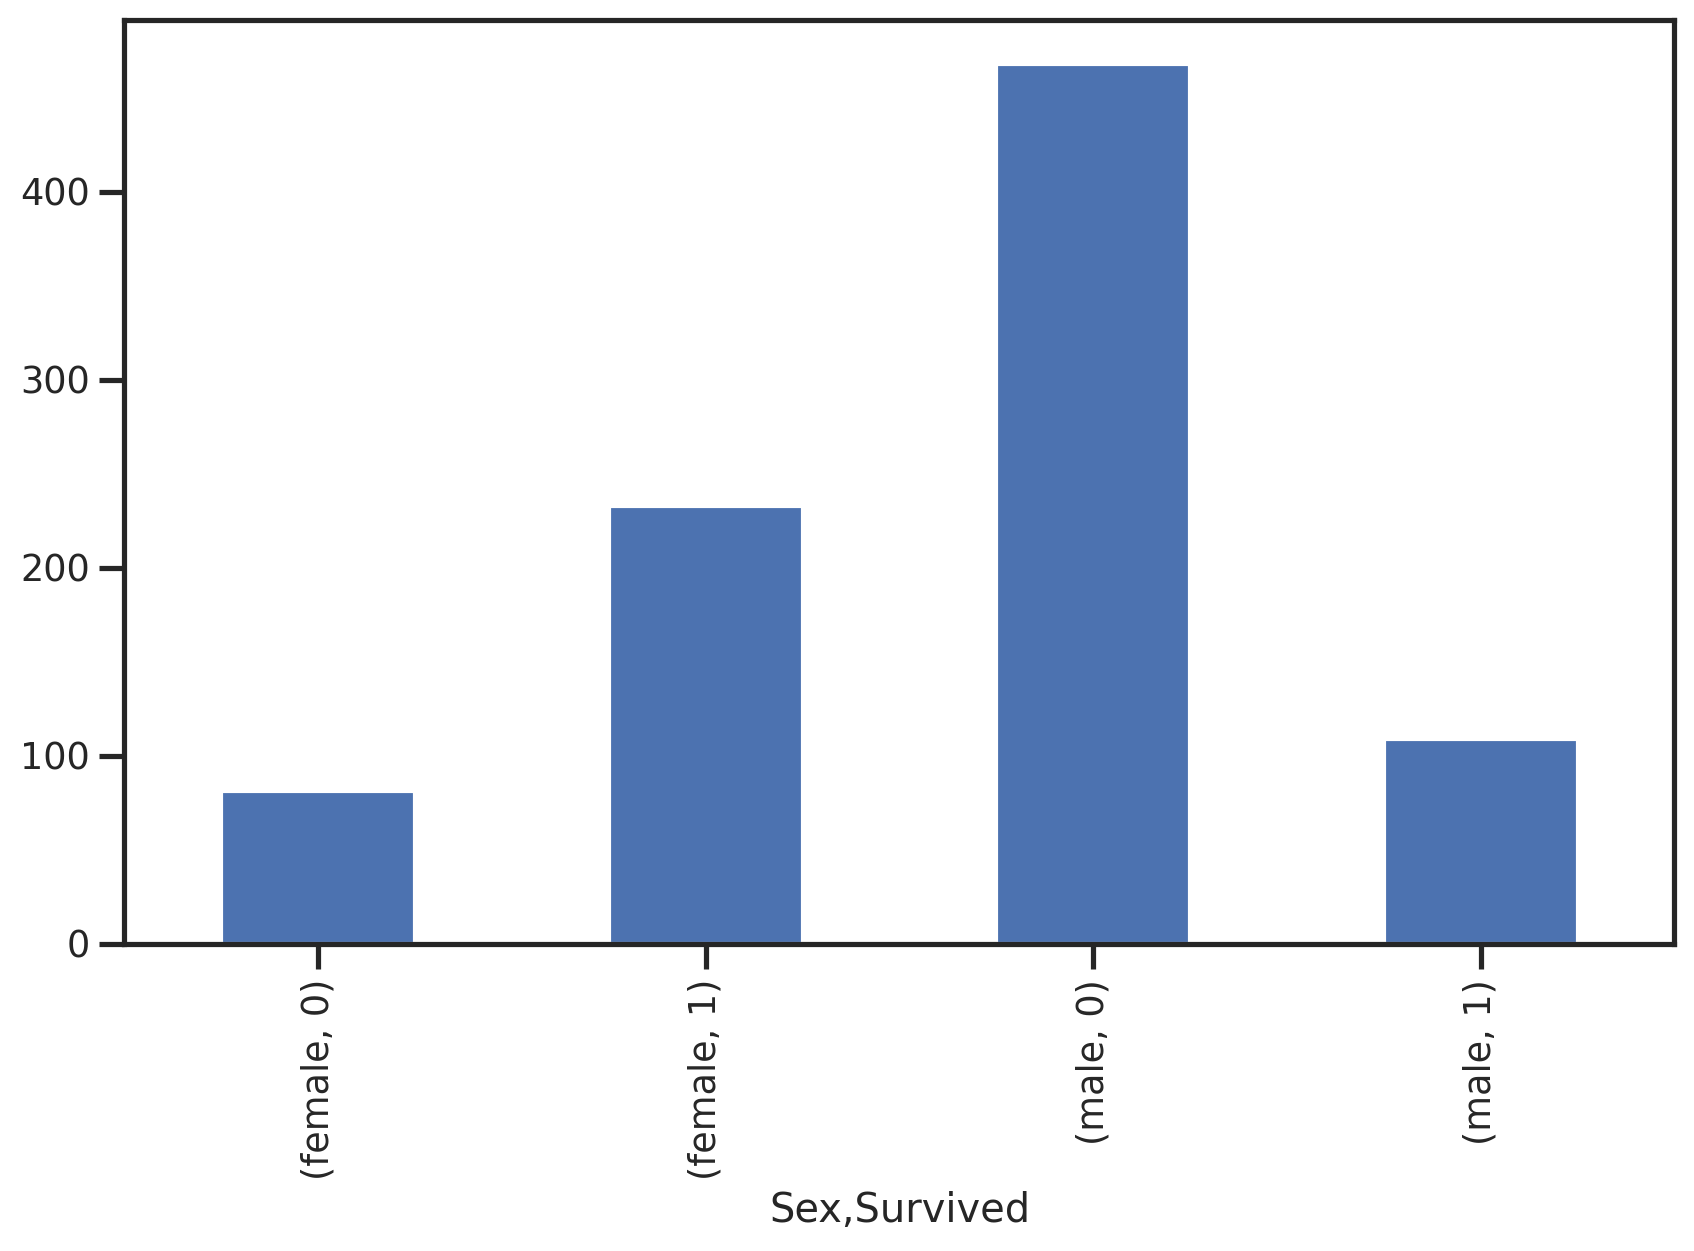

In [25]:
# it is useful to visualise a frequency distribution with a bar chart, which
# we have done in the last few weeks
(titanic
 .groupby(['Sex', 'Survived'])
 .size()
).plot.bar();

Then, something this is quite useful to analyse relationships, differences in groups, and so on:  conditional distributions. For example, what is the distribution of `Survived` conditioned on `Sex`?

In [26]:
titanic.query("Sex=='male'")['Survived'].value_counts(normalize=True)

0    0.811092
1    0.188908
Name: Survived, dtype: float64

In [27]:
titanic.query("Sex=='female'")['Survived'].value_counts(normalize=True)

1    0.742038
0    0.257962
Name: Survived, dtype: float64

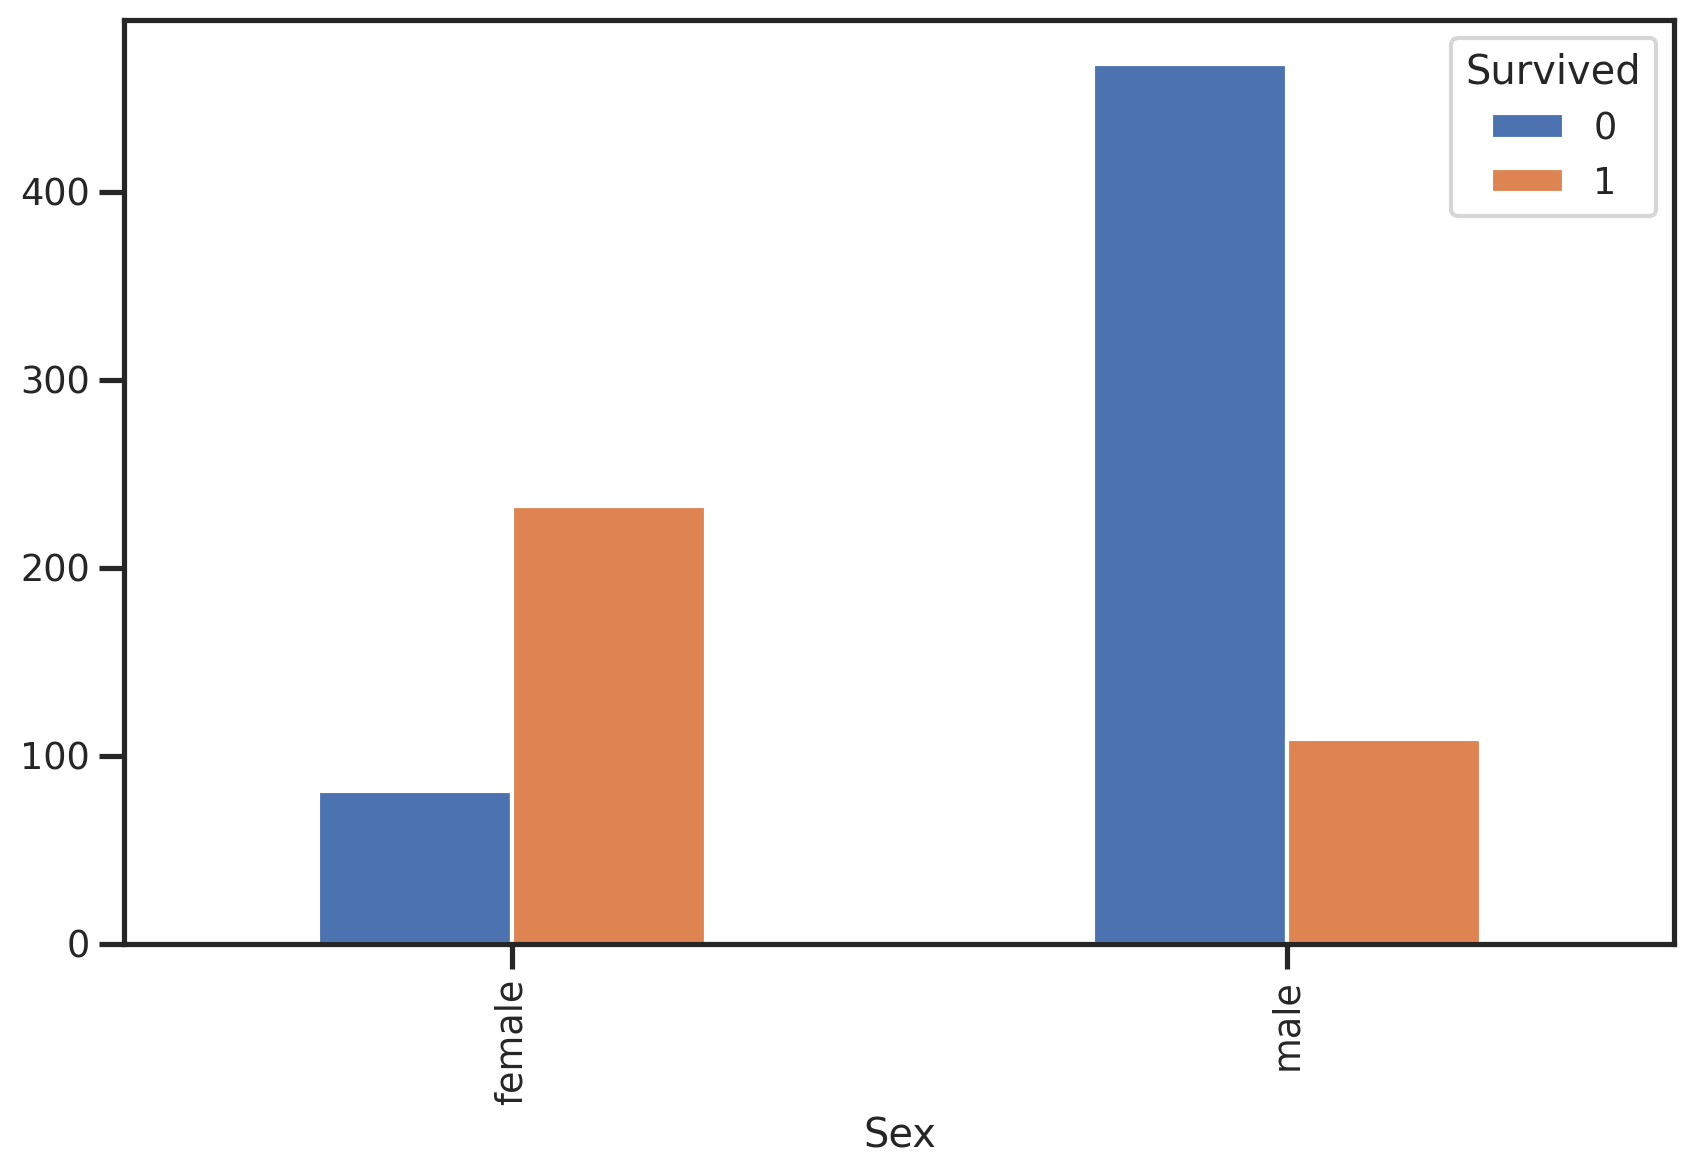

In [28]:
(titanic
 .groupby(['Sex', 'Survived'])
 .size()
 .unstack('Survived')
).plot.bar();

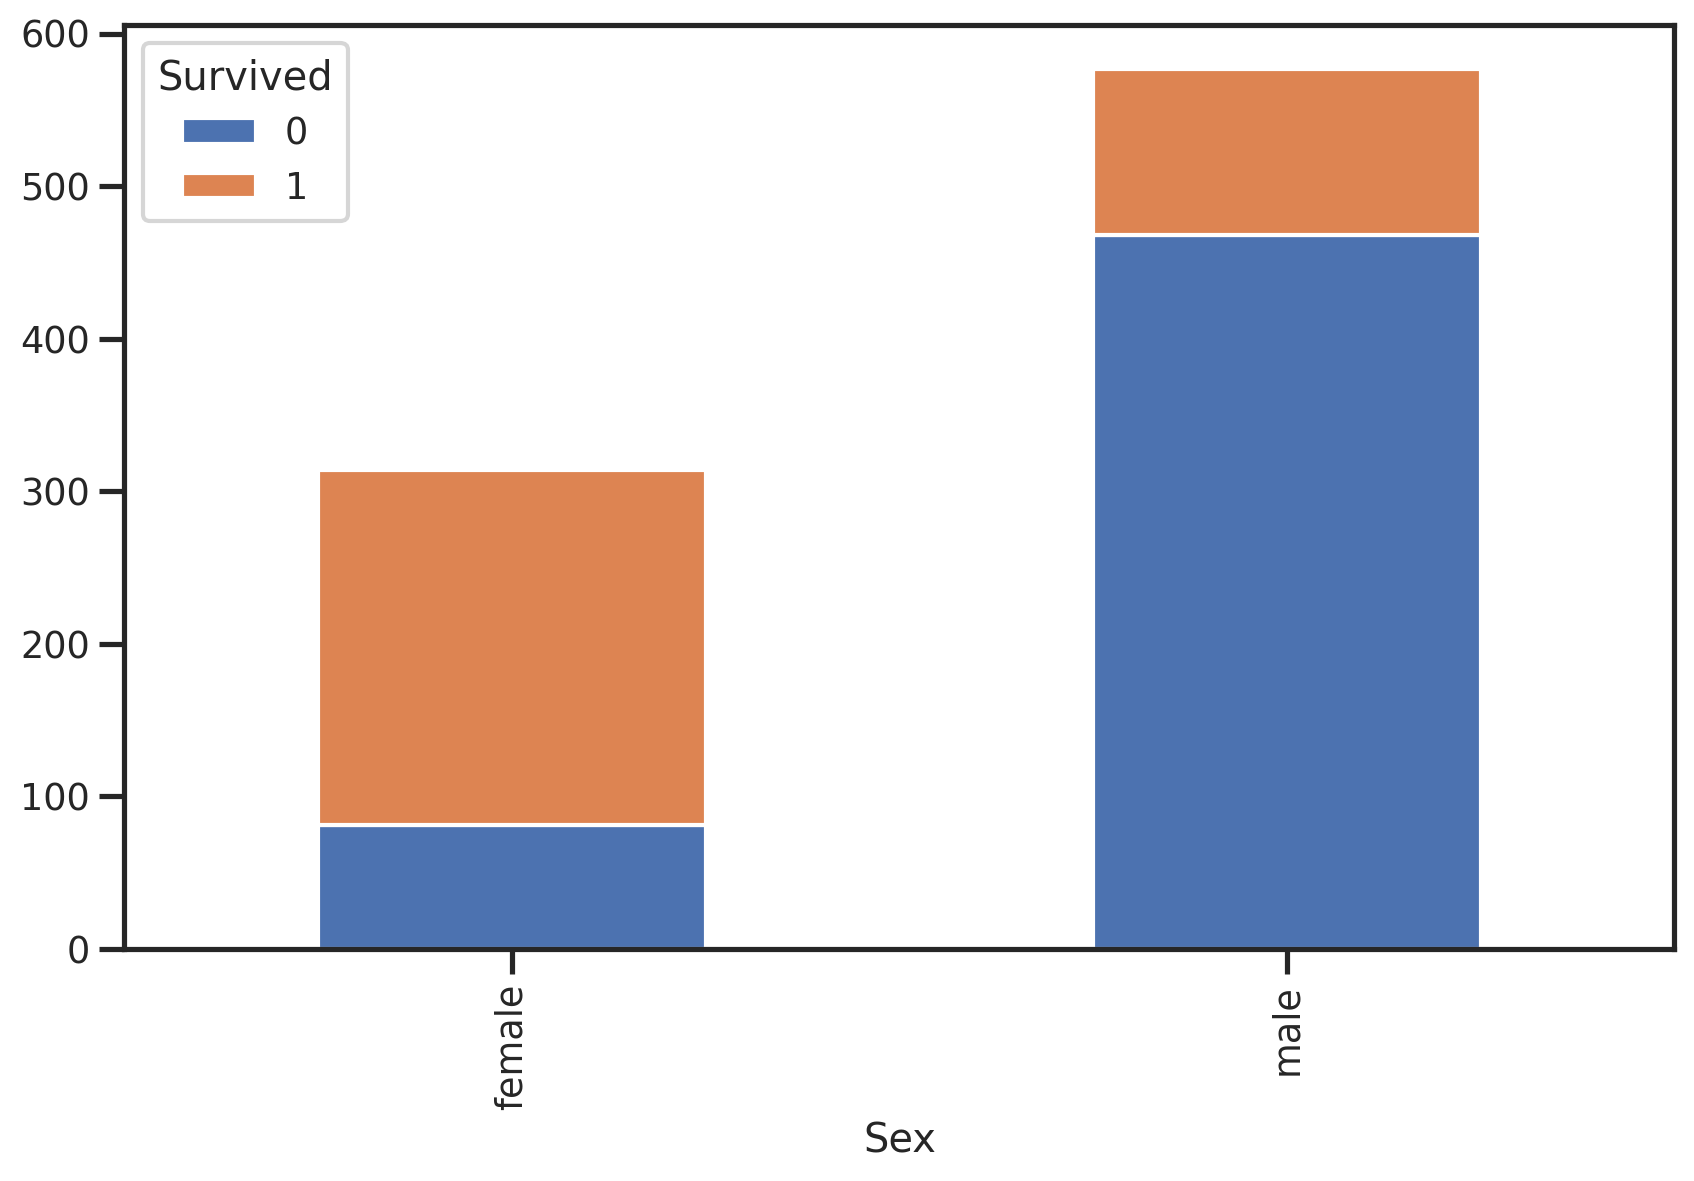

In [29]:
(titanic
 .groupby(['Sex', 'Survived'])
 .size()
 .unstack('Survived')
).plot.bar(stacked=True);

### Computing Conditional Probability Distributions (discrete; relative frequencies)

It would be nice to have a **conditional** `.value_counts()`...

In [30]:
(titanic
 .groupby(['Sex', 'Survived'])
 .size()
)

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
dtype: int64

In [31]:
(titanic
 .groupby(['Sex'])
 .size()
)

Sex
female    314
male      577
dtype: int64

Thanks for index alignment, we can obtain the relative frequency of `Survived` for each `Sex` group.

In [32]:
(titanic
 .groupby(['Sex', 'Survived'])
 .size()
 /
 titanic
 .groupby(['Sex'])
 .size()
)

Sex     Survived
female  0           0.257962
        1           0.742038
male    0           0.811092
        1           0.188908
dtype: float64

In [33]:
survived_cond_on_sex = (titanic
 .groupby(['Sex', 'Survived'])
 .size()
 /
 titanic
 .groupby(['Sex'])
 .size()
)

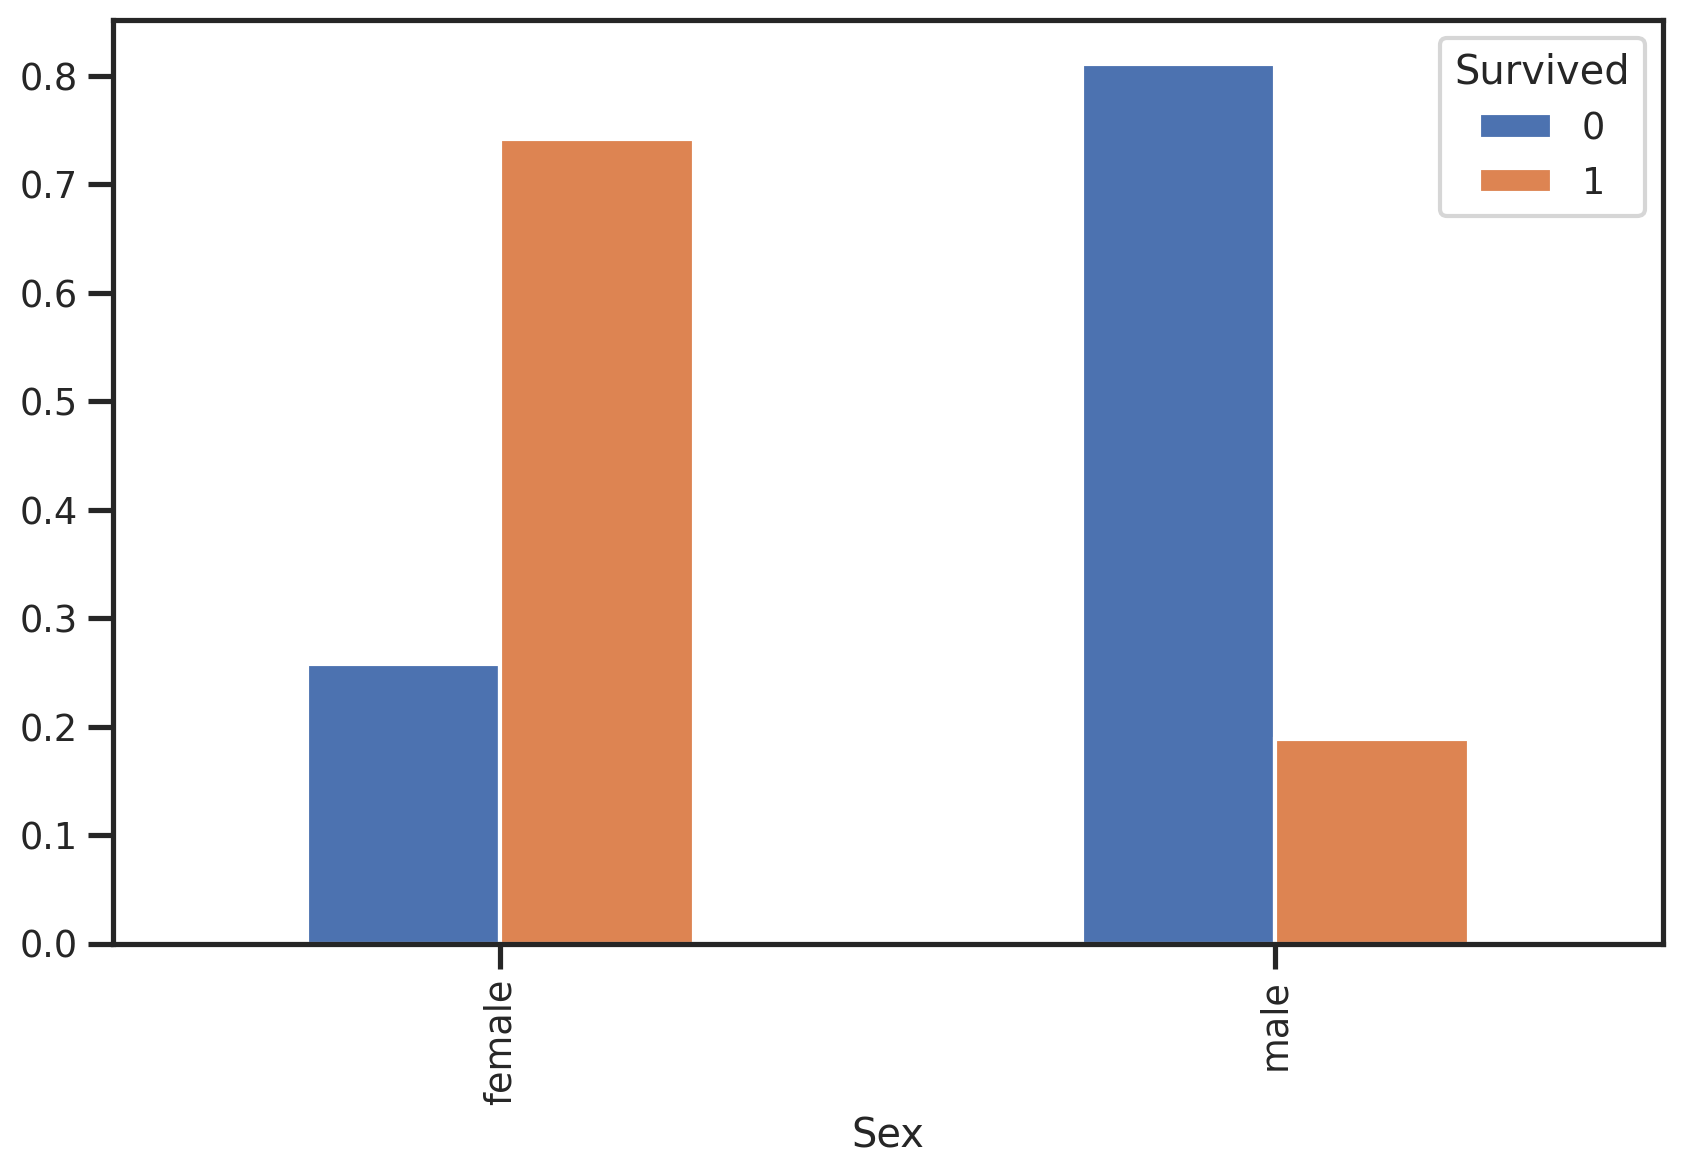

In [34]:
survived_cond_on_sex.unstack().plot.bar();

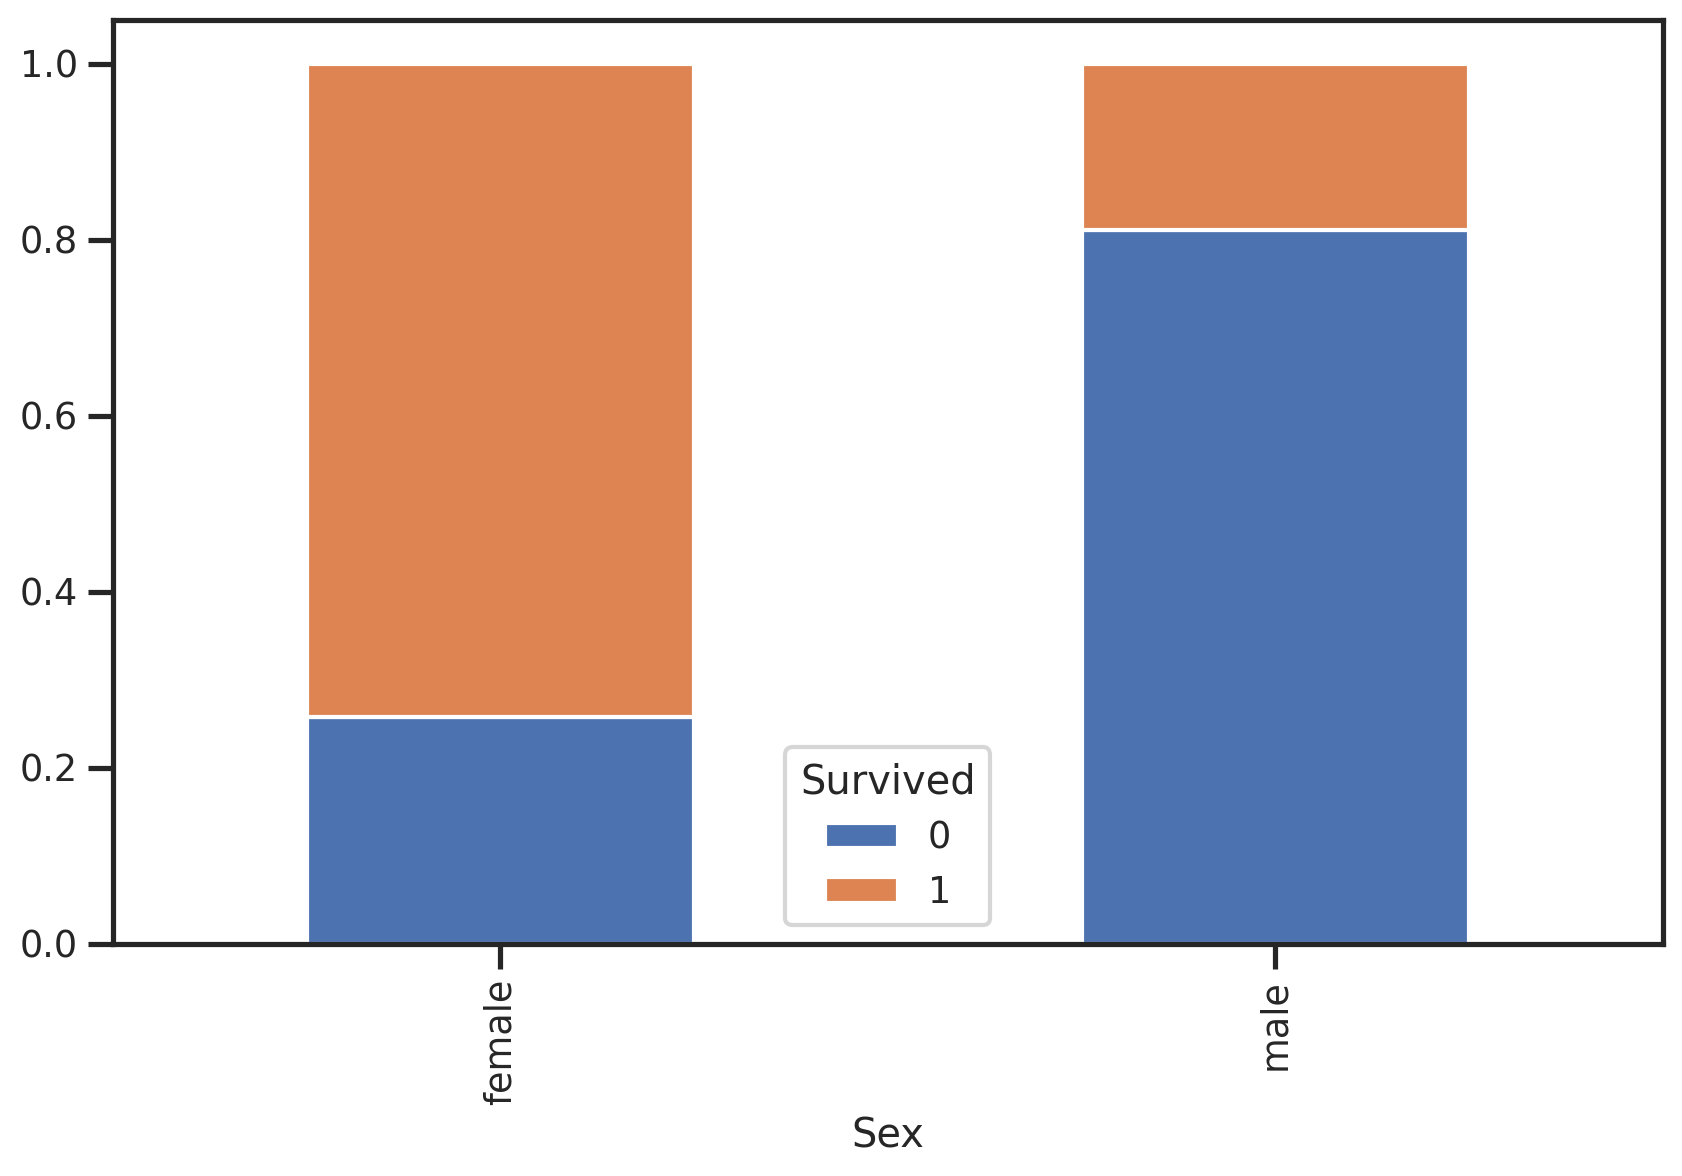

In [35]:
survived_cond_on_sex.unstack().plot.bar(stacked=True);

### Why not do it with `seaborn`?!

OK. In this case, we have to categorical features - `Sex` and `Survived`. The go-to plots would probably be `.countplot()` and `.barplot()`.

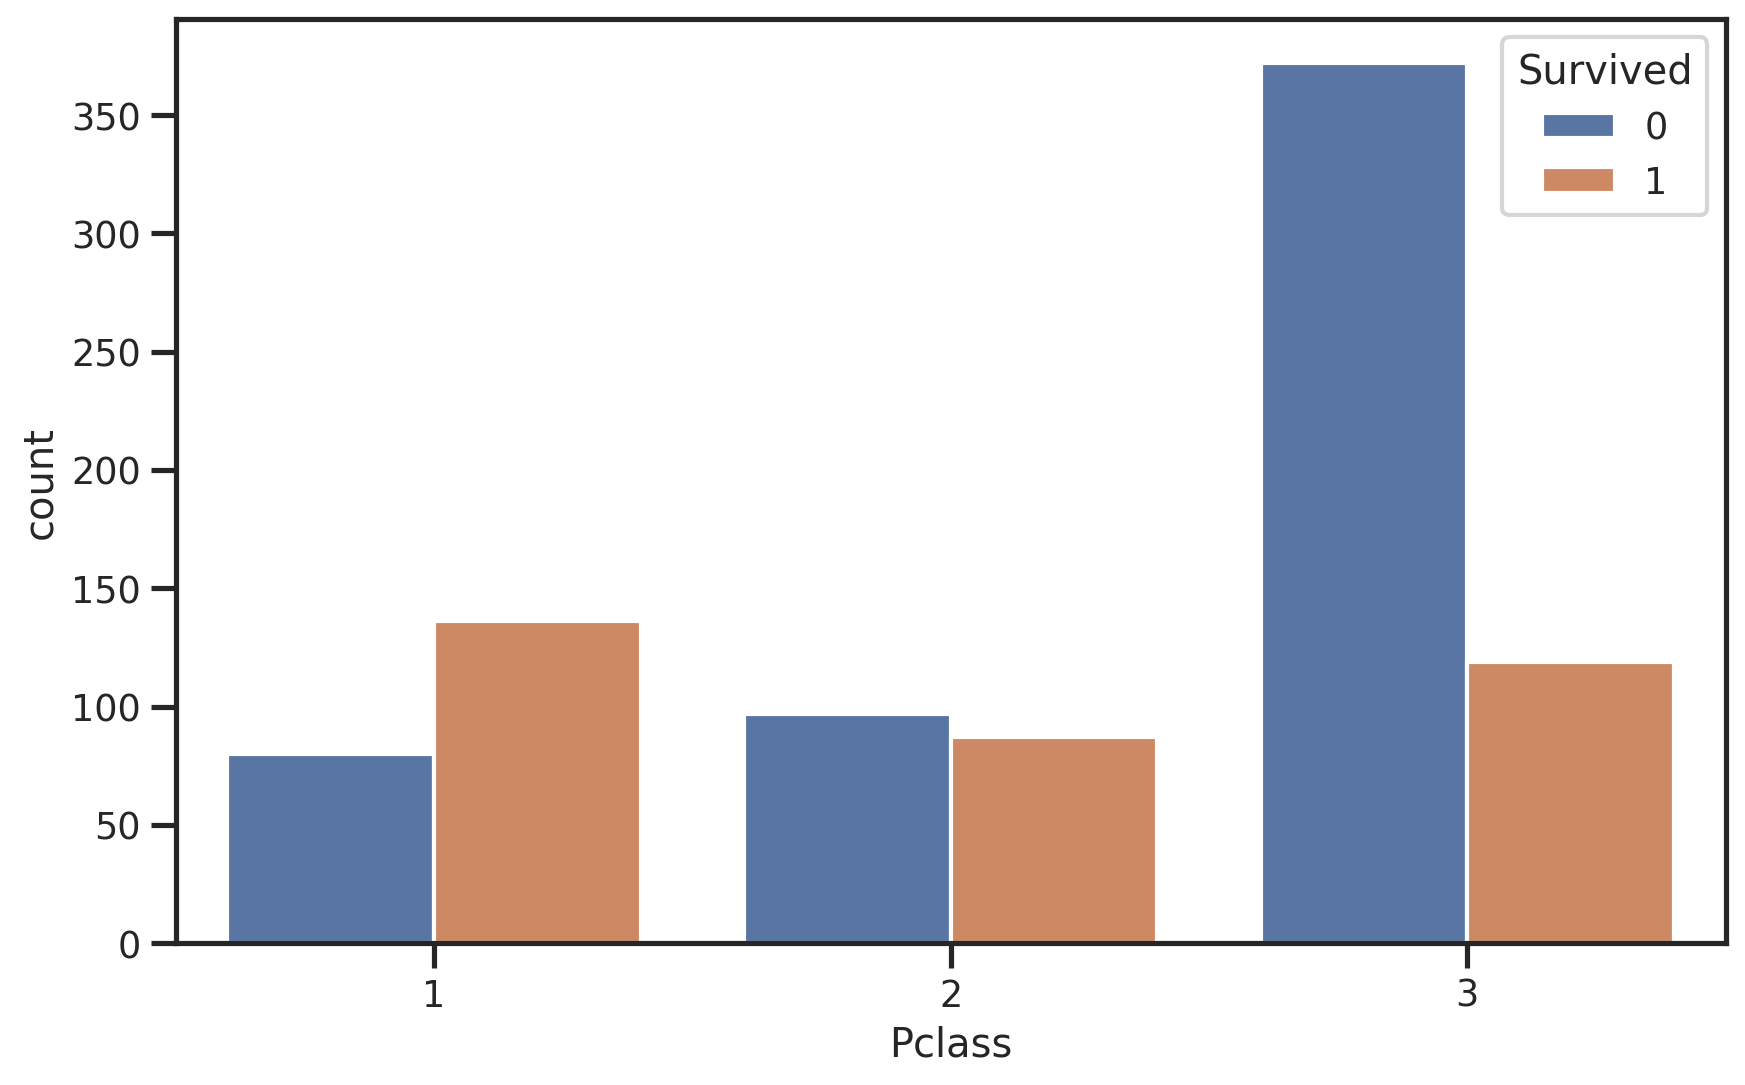

In [36]:
# here, `hue` is used to specify conditioning (of Survived on PClass)
sns.countplot(data=titanic, x="Pclass", hue="Survived");

No normalisation functionality, as far as I am aware, so we can try the more flexible `.barplot()`. Where as `.countplot()` does the summarisation as `count`, `.barplot()` will do `mean` by default.

In [37]:
df = (titanic
 .groupby(['Pclass', 'Survived'])
 .size()
 /
 titanic
 .groupby(['Pclass'])
 .size()
)

In [38]:
df = df.rename('prob').reset_index()

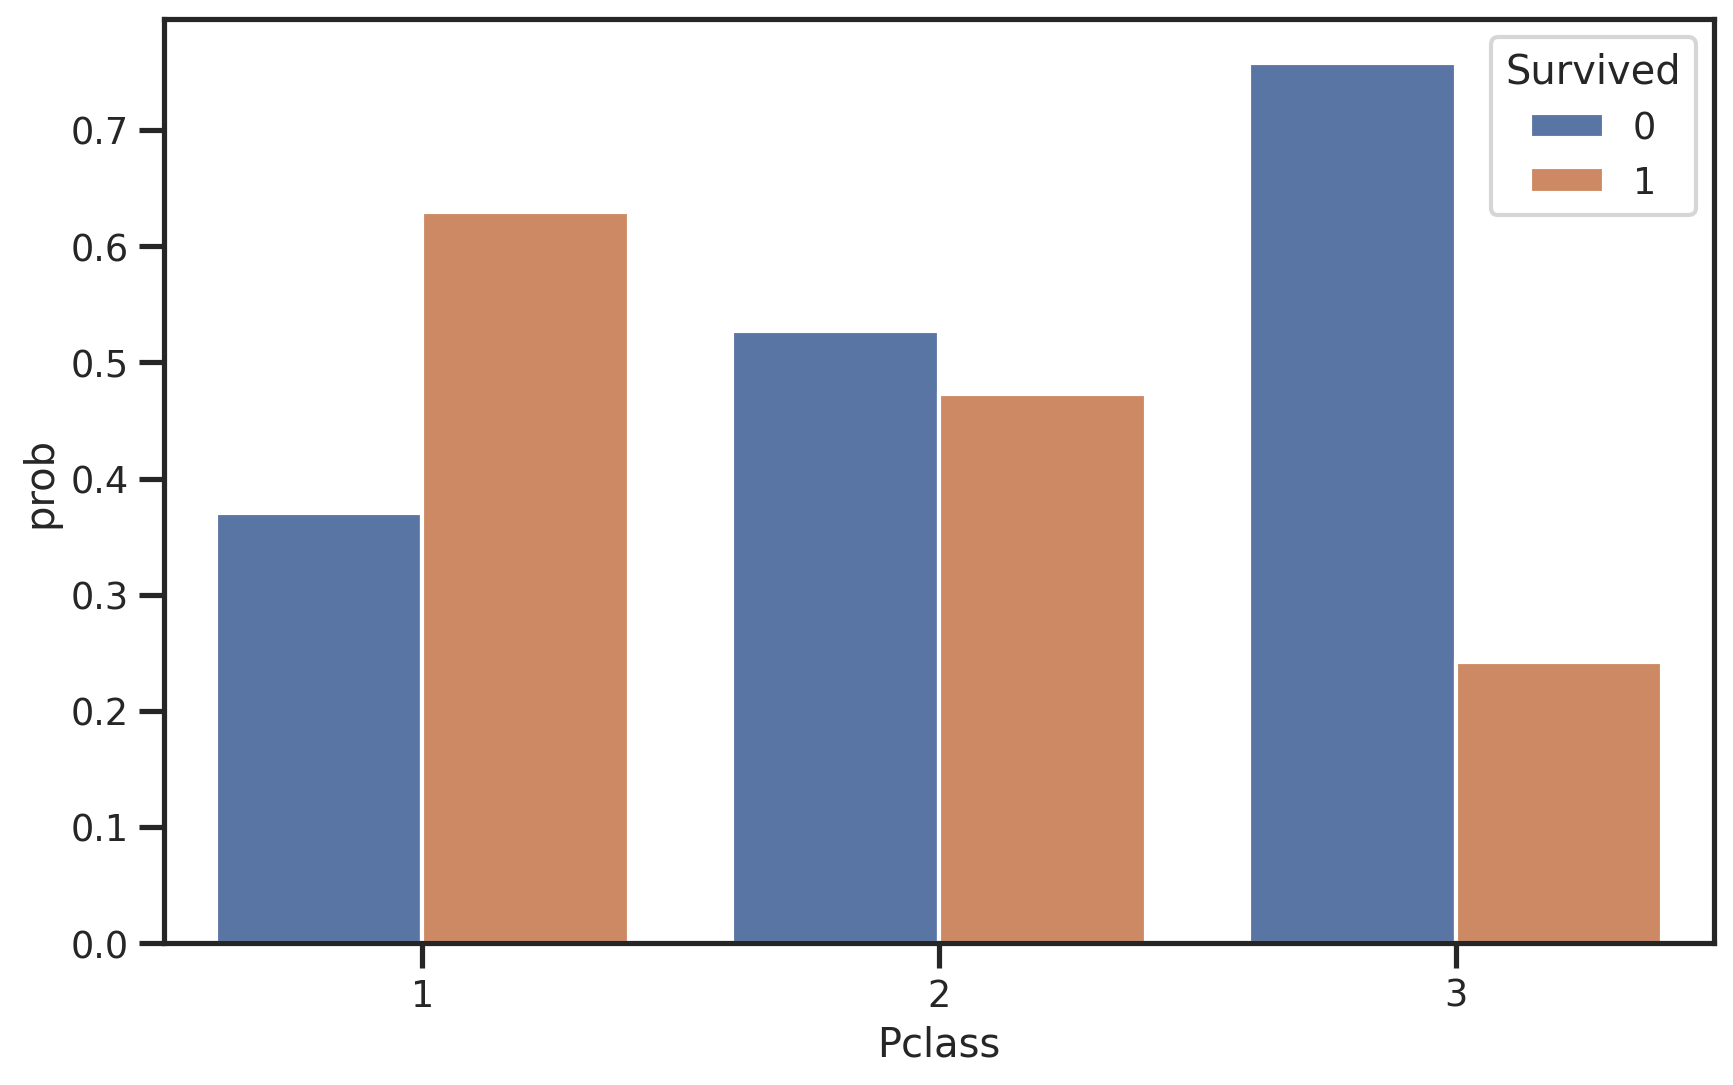

In [39]:
sns.barplot(data=df, x="Pclass", y="prob", hue="Survived");

Still, no stacked bar charts - apparently, `seaborn`'s creator doesn't like them. But one can have stacked histograms (quantitative)...

### A Nice Opportunity to Introduce Reusable Code with User-Defined Functions

In [40]:
def cond_prob_dist(df, A, B):
    """returns a pandas Series with the computation of p(B|A)
    
    A and B are lists of columns labels. df is the DataFrame from which the
    distribution will be computed.
    """
    
    prob_dist = (
        df
        .groupby(A + B)  # list concatenation
        .size()
        /
        df
        .groupby(A)
        .size()
    )
    
    return prob_dist

In [41]:
cond_prob_dist(titanic, ['Pclass'], ['Survived'])

Pclass  Survived
1       0           0.370370
        1           0.629630
2       0           0.527174
        1           0.472826
3       0           0.757637
        1           0.242363
dtype: float64

In [42]:
cond_prob_dist(titanic, ['Sex'], ['Survived'])

Sex     Survived
female  0           0.257962
        1           0.742038
male    0           0.811092
        1           0.188908
dtype: float64

In [43]:
cond_prob_dist(titanic, ['Embarked'], ['Survived'])

Embarked  Survived
C         0           0.446429
          1           0.553571
Q         0           0.610390
          1           0.389610
S         0           0.663043
          1           0.336957
dtype: float64


## Exercises

What is total number of passengers by sex?

In [47]:
(titanic.groupby(['Sex']).size())

Sex
female    314
male      577
dtype: int64

What is the number of passengers by port of embarkment?

In [50]:
(titanic.groupby(['Embarked']).size())

Embarked
C    168
Q     77
S    644
dtype: int64

What is the mean age by sex?

In [54]:
(titanic.groupby(['Sex'])['Age'].mean())

Sex
female    27.915709
male      30.726645
Name: Age, dtype: float64

How many passengers travelled alone, by sex?

What is the mean fare value by travel class?

What is the frequency distribution of survived/died by travel class?

How many passengers survived and died, by sex?

What are the highest values for `sibsp` (number of siblings/spouses) and `parch` (number of parents/children) by travel class?

Compare the average fear paid by men and women, broken down in the three different classes.